### Import Packages

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Global attributes

In [2]:
mixed_dir = {
    'machine': '../machine/mixed/',
    'nature': '../nature/mixed/',
    'human': '../human/mixed/'
}

clean_dir = {
    'machine': '../machine/clean/',
    'nature': '../nature/clean/',
    'human': '../human/clean/'
}

test_dir = {
    'input': '../test_data/',
    'output': '../test_output/',
    'visual': '../visualization/'
}

### SNR

In [3]:
def calculate_snr(clean_signal, denoised_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels.
    
    Args:
    clean_signal (torch.Tensor): Ground truth clean signal, shape (1, 1, H, W)
    denoised_signal (torch.Tensor): Model's output signal, shape (1, 1, H, W)
    
    Returns:
    float: SNR value in decibels.
    """
    assert clean_signal.shape == denoised_signal.shape, "Shapes of input tensors must match."
    clean_signal = clean_signal.squeeze()
    denoised_signal = denoised_signal.squeeze()
    signal_power = torch.mean(clean_signal ** 2)
    noise_power = torch.mean((clean_signal - denoised_signal) ** 2)
    if noise_power == 0:
        return float('inf')
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()

### Preprocess Data

In [4]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [5]:
def load_spectrogram_from_npy(mixed_dir, clean_dir = None):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(mixed_dir))
    
    print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(mixed_dir)):
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                if (clean_dir != None): clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                if (clean_dir != None): clean_mel_spectrogram_db = np.load(clean_path)

                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                if (clean_dir != None): clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                if (clean_dir != None): clean_mel_spectrograms.append(clean_mel_tensor)
                
                bar()
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    if (clean_dir != None): return mixed_mel_spectrograms, clean_mel_spectrograms
    else: return mixed_mel_spectrograms

In [6]:
machine_mixed_mel_spectrograms, machine_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['machine'], clean_dir['machine'])
nature_mixed_mel_spectrograms, nature_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['nature'], clean_dir['nature'])
human_mixed_mel_spectrograms, human_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['human'], clean_dir['human'])
test_mixed_mel_spectrograms = load_spectrogram_from_npy(test_dir['input'])
mixed_mel_spectrograms = machine_mixed_mel_spectrograms + nature_mixed_mel_spectrograms + human_mixed_mel_spectrograms
clean_mel_spectrograms = machine_clean_mel_spectrograms + nature_clean_mel_spectrograms + human_clean_mel_spectrograms
target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_spectrograms[0].shape[2])]
mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in mixed_mel_spectrograms]
clean_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in clean_mel_spectrograms]
test_mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in test_mixed_mel_spectrograms]
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

Loading 7500 files...
|████████████████████████████████████████| 7500/7500 [100%] in 2:24.4 (51.92/s)  ▆█▆ 935/7500 [12%] in 17s (~2:00, 54. ▂▄▆ 943/7500 [13%] in 18s (~2:00, 52. ▅▃▁ 967/7500 [13%] in 19s (~2:00, 52. ▂▂▄ 978/7500 [13%] in 19s (~2:00, 52. ▁▃▅ 1478/7500 [20%] in 30s (~2:00, 49 ▅▃▁ 1700/7500 [23%] in 35s (~1:50, 48 ▅▇▇ 1887/7500 [25%] in 38s (~1:50, 49 ▄▂▂ 2207/7500 [29%] in 43s (~1:40, 51 ▄▆█ 2233/7500 [30%] in 44s (~1:40, 51 █▆▄ 2368/7500 [32%] in 46s (~1:30, 51 ▂▂▄ 2445/7500 [33%] in 47s (~1:30, 52 ▇▅▃ 2833/7500 [38%] in 54s (~1:20, 52 ▅▇▇ 2863/7500 [38%] in 54s (~1:20, 52 ▇▇▅ 3101/7500 [41%] in 59s (~1:20, 52 ▇▅▃ 3457/7500 [46%] in 1:05 (~1:10, 5 ▁▃▅ 3583/7500 [48%] in 1:08 (~1:10, 5 ▂▄▆ 3583/7500 [48%] in 1:09 (~1:10, 5 ▇▅▃ 3735/7500 [50%] in 1:11 (~1:10, 5 ▇▅▃ 3795/7500 [51%] in 1:12 (~1:10, 5 ▅▃▁ 3805/7500 [51%] in 1:12 (~1:10, 5 ▄▂▂ 3809/7500 [51%] in 1:12 (~1:10, 5 ▃▁▃ 3857/7500 [51%] in 1:13 (~1:00, 5 ▂▂▄ 3861/7500 [51%] in 1:13 (~1:00, 5 ▂▂▄ 4129/7500 [55%] in 

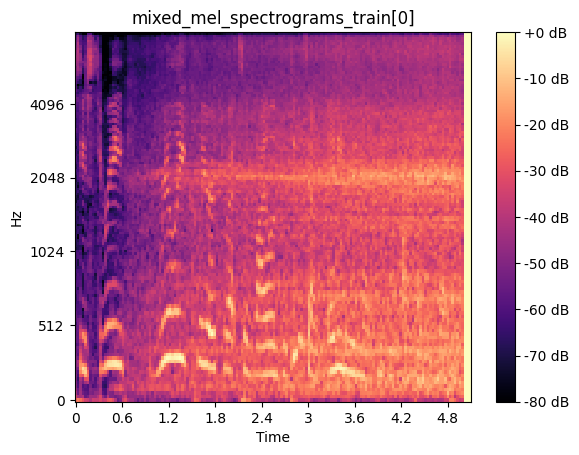

In [7]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='mixed_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "mixed_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

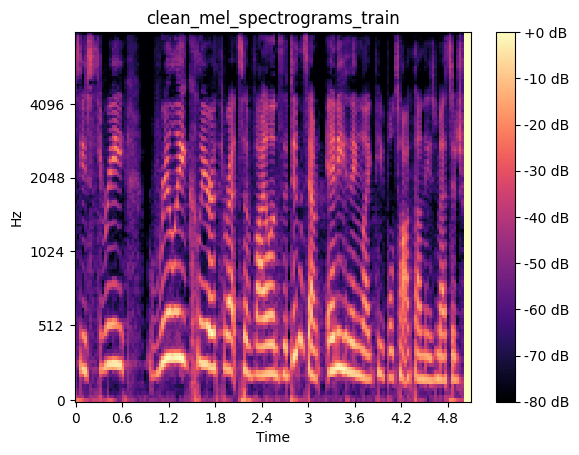

In [8]:
fig, ax = plt.subplots()
img = librosa.display.specshow(clean_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='clean_mel_spectrograms_train')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "clean_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Training

In [9]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

In [10]:
# Model參數
num_epochs = 100
batch_size = 256
learning_rate = 0.5
lr_decay_step = 20
lr_decay_gamma = 0.6

In [11]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


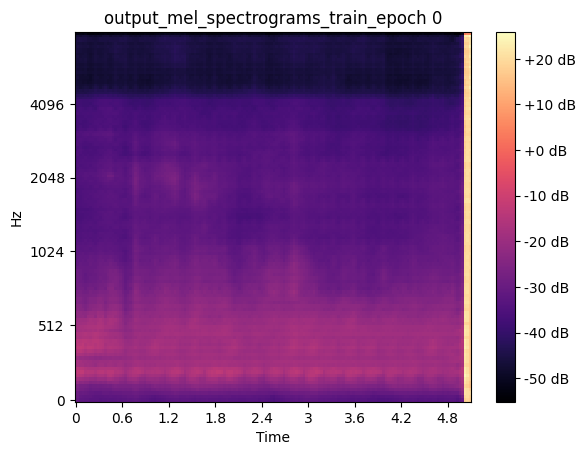

Epoch [1/100], Training Loss: 687.224792480469, Validation Loss: 654.117553710938, Learning Rate: 0.50000000
Epoch [2/100], Training Loss: 188.721374511719, Validation Loss: 179.061584472656, Learning Rate: 0.50000000
Epoch [3/100], Training Loss: 113.757858276367, Validation Loss: 108.764053344727, Learning Rate: 0.50000000
Epoch [4/100], Training Loss: 70.830139160156, Validation Loss: 68.002670288086, Learning Rate: 0.50000000
Epoch [5/100], Training Loss: 46.243843078613, Validation Loss: 45.000564575195, Learning Rate: 0.50000000
Epoch [6/100], Training Loss: 35.715122222900, Validation Loss: 35.159507751465, Learning Rate: 0.50000000
Epoch [7/100], Training Loss: 29.736833572388, Validation Loss: 29.765750885010, Learning Rate: 0.50000000
Epoch [8/100], Training Loss: 25.599565505981, Validation Loss: 26.108425140381, Learning Rate: 0.50000000
Epoch [9/100], Training Loss: 22.745399475098, Validation Loss: 23.325208663940, Learning Rate: 0.50000000
Epoch [10/100], Training Loss: 

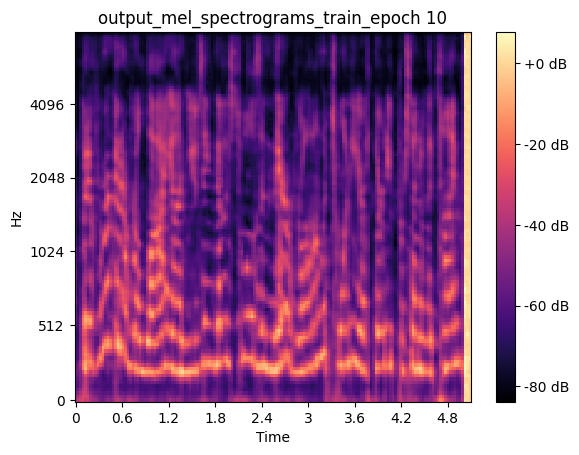

Epoch [11/100], Training Loss: 19.122104644775, Validation Loss: 19.731040954590, Learning Rate: 0.50000000
Epoch [12/100], Training Loss: 17.840753555298, Validation Loss: 18.704599380493, Learning Rate: 0.50000000
Epoch [13/100], Training Loss: 16.846099853516, Validation Loss: 17.814617156982, Learning Rate: 0.50000000
Epoch [14/100], Training Loss: 16.006227493286, Validation Loss: 17.128089904785, Learning Rate: 0.50000000
Epoch [15/100], Training Loss: 15.343225479126, Validation Loss: 16.429811477661, Learning Rate: 0.50000000
Epoch [16/100], Training Loss: 14.714494705200, Validation Loss: 15.837961196899, Learning Rate: 0.50000000
Epoch [17/100], Training Loss: 14.282550811768, Validation Loss: 15.406491279602, Learning Rate: 0.50000000
Epoch [18/100], Training Loss: 13.827279090881, Validation Loss: 14.793430328369, Learning Rate: 0.50000000
Epoch [19/100], Training Loss: 13.450015068054, Validation Loss: 14.159296035767, Learning Rate: 0.50000000
Epoch [20/100], Training Los

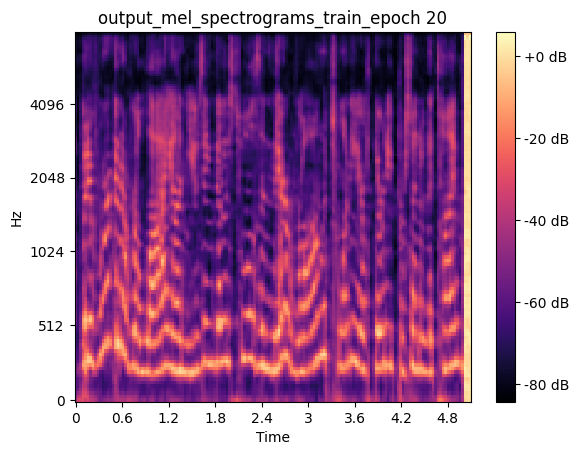

Epoch [21/100], Training Loss: 12.462427139282, Validation Loss: 13.023508071899, Learning Rate: 0.30000000
Epoch [22/100], Training Loss: 12.161368370056, Validation Loss: 12.775431632996, Learning Rate: 0.30000000
Epoch [23/100], Training Loss: 11.905135154724, Validation Loss: 12.577730178833, Learning Rate: 0.30000000
Epoch [24/100], Training Loss: 11.683311462402, Validation Loss: 12.389556884766, Learning Rate: 0.30000000
Epoch [25/100], Training Loss: 11.473072052002, Validation Loss: 12.230874061584, Learning Rate: 0.30000000
Epoch [26/100], Training Loss: 11.276628494263, Validation Loss: 12.081001281738, Learning Rate: 0.30000000
Epoch [27/100], Training Loss: 11.095643043518, Validation Loss: 11.943243980408, Learning Rate: 0.30000000
Epoch [28/100], Training Loss: 10.923985481262, Validation Loss: 11.804124832153, Learning Rate: 0.30000000
Epoch [29/100], Training Loss: 10.775180816650, Validation Loss: 11.663284301758, Learning Rate: 0.30000000
Epoch [30/100], Training Los

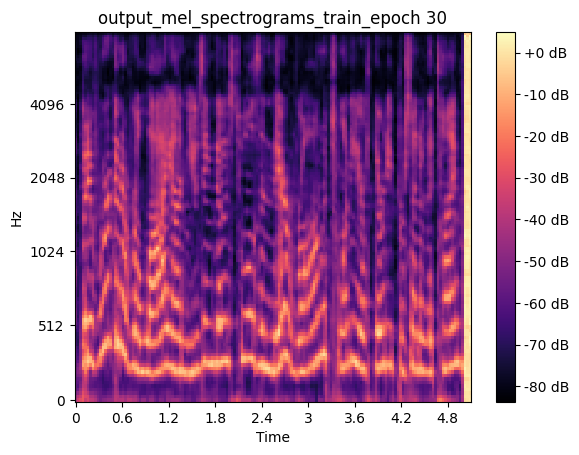

Epoch [31/100], Training Loss: 10.484143257141, Validation Loss: 11.423913955688, Learning Rate: 0.30000000
Epoch [32/100], Training Loss: 10.354173660278, Validation Loss: 11.297073364258, Learning Rate: 0.30000000
Epoch [33/100], Training Loss: 10.240464210510, Validation Loss: 11.179392814636, Learning Rate: 0.30000000
Epoch [34/100], Training Loss: 10.106844902039, Validation Loss: 11.073330879211, Learning Rate: 0.30000000


In [ ]:
from torch.optim.lr_scheduler import StepLR
model = DenoiseAutoencoder()

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
validation_losses = []
training_snrs = []
validation_snrs = []

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    sum_loss = 0
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
        sum_loss += loss.item()
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count training loss and SNR
    snr = calculate_snr(clean, outputs)
    training_losses.append(sum_loss / len(dataloader))
    training_snrs.append(snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_train_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_train_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）
    
    # count validation loss and SNR
    val_output = model(next(iter(dataloader_val))[0])
    val_loss = criterion(val_output, next(iter(dataloader_val))[1])
    val_snr = calculate_snr(next(iter(dataloader_val))[1], val_output)
    validation_losses.append(val_loss.item())
    validation_snrs.append(val_snr)
    
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

### Plot Loss

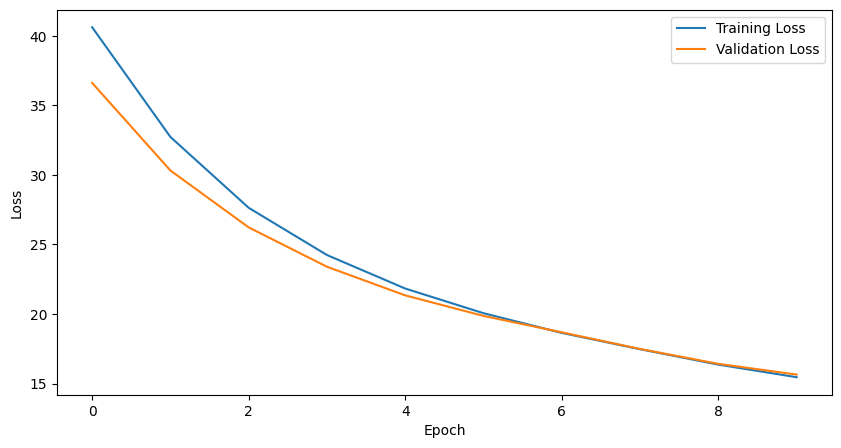

In [ ]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses[5:], label="Training Loss")
plt.plot(validation_losses[5:], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "loss_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Plot SNR

Training SNR:   22.96170044 dB
Validation SNR: 22.96170044 dB


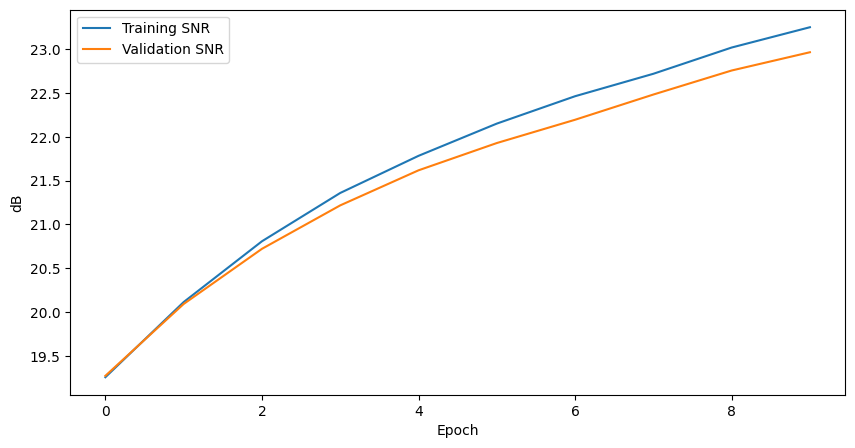

In [ ]:
# print the SNR of the first training sample
model.eval()

with torch.no_grad():
    train_output = model(next(iter(dataloader_val))[0])
    snr = calculate_snr(next(iter(dataloader_val))[1], train_output)
    print(f"Training SNR:   {snr:.8f} dB")

with torch.no_grad():
    val_output = model(next(iter(dataloader_val))[0])
    snr = calculate_snr(next(iter(dataloader_val))[1], val_output)
    print(f"Validation SNR: {snr:.8f} dB")
    
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_snrs[5:], label="Training SNR")
plt.plot(validation_snrs[5:], label="Validation SNR")
plt.xlabel("Epoch")
plt.ylabel("dB")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "snr_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

torch.Size([1, 1, 128, 160])
torch.Size([1, 1, 128, 157])


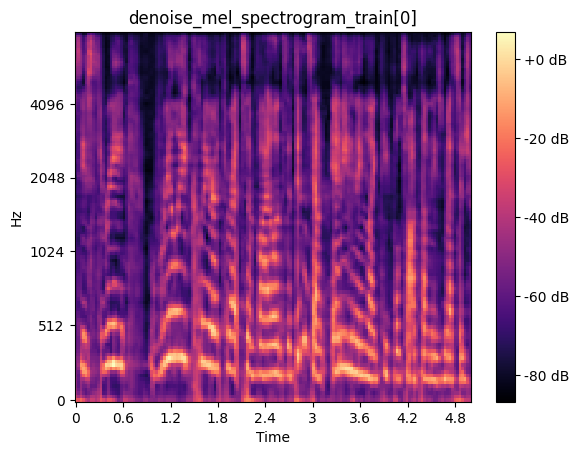

In [ ]:
model.eval()
# 這行超久要怎麼解
denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_train[0]).unsqueeze(0))
print(denoised_output.shape)
denoised_output = denoised_output[:, :, :, :157]
print(denoised_output.shape)
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Prediction

In [ ]:
# # MelSpectrogram參數 (勿動)
# n_mels = 128                # 保持 Mel 頻譜圖的解析度
# n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
# hop_length = 512            # 保持 hop_length 為 n_fft 的一半
# win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
# sample_rate = 16000         # 採樣率保持不變，適合語音處理
# f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
# duration = 5                # 音頻時長為 5 秒

In [ ]:
# # MIXED
# mixed_waveform, sample_rate = librosa.load('test2.wav', sr=sample_rate)

# # if sr != sample_rate:
# #     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# # cut to fit the duration
# if len(mixed_waveform) > sample_rate * duration:
#     mixed_waveform = mixed_waveform[:sample_rate * duration]

# mixed_mel_spectrogram = librosa.feature.melspectrogram(
#     y=mixed_waveform,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_mels=n_mels
# )

# mixed_mel_spectrogram_db = librosa.power_to_db(
#     mixed_mel_spectrogram, 
#     ref=np.max, 
#     amin=1e-10  # 避免log(0)
# )

# # mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram, dtype=torch.float32).squeeze().unsqueeze(0)
# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
# # mixed_mel_tensor = torch.tensor(np.load('nature_mixed.npy'), dtype=torch.float32).squeeze().unsqueeze(0)

# mixed_mel = mixed_mel_tensor
# mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
# mixed_output = librosa.db_to_power(mixed_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(
#     mixed_output,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_iter=512
# )

# audio_signal = audio_signal / np.max(np.abs(audio_signal))


# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

In [ ]:
# # DENOISED
# model.eval()  # 设置模型为评估模式
# # print(mixed_mel_tensor.shape)
# print(test_mixed_mel_spectrograms[0].shape)
# mixed_mel_np_array = np.array(test_mixed_mel_spectrograms)
# for i in range(len(mixed_mel_np_array)):
#     mixed_mel_np_array[i] = mixed_mel_np_array[i][:, :, :157]
# print(mixed_mel_np_array.shape)

# mixed_mel_tensor = torch.tensor(mixed_mel_np_array, dtype=torch.float32)

# denoised_output = model(mixed_mel_tensor)
# denoised_output = denoised_output[:, :, :, :157]
# print(denoised_output.shape)
# denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
# denoised_output = librosa.db_to_power(denoised_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
# audio_signal = audio_signal / np.max(np.abs(audio_signal))

# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
